# GRAPHING VIOLIN PLOTSFOR DIFFUSION PSEUDOTIME ANALYSIS (+ DIFFERENCE IN MEDIAN BAR PLOT)

In [85]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from sklearn import preprocessing
import magic
import math
import rpy2
import bbknn
import anndata as ad
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from statannotations.Annotator import Annotator

from IPython.display import clear_output
import pickle
import os
import sys

import scanpy as sc
import scanpy.external as sce

from numpy import ones,vstack
from numpy.linalg import lstsq

In [86]:
#read in anndata objects w/ dpt pseudotime values calculated
hu_rna_concat_ag = sc.read_h5ad("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu/hu_rna_concat_ag.h5ad")
mu_rna_concat_ag = sc.read_h5ad("C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu/mu_rna_concat_ag.h5ad")

In [93]:
#function for converting integrated_snn_res.0.4 clusters in humans to their subcell name
def hu_subcell_conv (row):
    if row['integrated_snn_res.0.4'] == "0":
        return "Spn_I"
    if row['integrated_snn_res.0.4'] == "1":
        return "Spn_III"
    if row['integrated_snn_res.0.4'] == "2":
        return "Spn_II"
    if row['integrated_snn_res.0.4'] == "3":
        return "Bas_II"
    if row['integrated_snn_res.0.4'] == "4":
        return "Bas_I"
    if row['integrated_snn_res.0.4'] == "5":
        return "Cyc_I"
    if row['integrated_snn_res.0.4'] == "6":
        return "Bas_III"
    if row['integrated_snn_res.0.4'] == "7":
        return "Cyc_III"
    if row['integrated_snn_res.0.4'] == "8":
        return "Cyc_II"
    if row['integrated_snn_res.0.4'] == "9":
        return "Spn_IFN"
    if row['integrated_snn_res.0.4'] == "10":
        return "Grn"
    if row['integrated_snn_res.0.4'] == "11":
        return "Spn_REDOX"
    else:
        return "broke"

In [94]:
#function for converting subcell types into simplified groups
def simple_subcell_conv (row):
    if row['subcell'] == 'Bas_I':
        return "Basal"
    if row['subcell'] == 'Bas_II':
        return "Basal"
    if row['subcell'] == 'Bas_III':
        return "Basal"
    if row['subcell'] == 'Bas_IFN':
        return "Basal"
    if row['subcell'] == 'Cyc_I':
        return "Cycling"
    if row['subcell'] == 'Cyc_II':
        return "Cycling"
    if row['subcell'] == 'Cyc_III':
        return "Cycling"
    if row['subcell'] == 'Spn_I':
        return "Spinous"
    if row['subcell'] == 'Spn_II':
        return "Spinous"
    if row['subcell'] == 'Spn_III':
        return "Spinous"
    if row['subcell'] == 'Spn_IFN':
        return "Spinous"
    if row['subcell'] == 'Spn_REDOX':
        return "Spinous"
    if row['subcell'] == 'Grn':
        return "Granular"
    else:
        return "broke"

In [95]:
#fix human subcell identity (add spinous IFN) (original imported annotations from seurat object are incorrect)
hu_rna_concat_ag.obs['subcell'] = hu_rna_concat_ag.obs.apply(lambda row: hu_subcell_conv(row), axis=1)

In [97]:
#create simple subcell
hu_rna_concat_ag.obs['simple_subcell'] = hu_rna_concat_ag.obs.apply(lambda row: simple_subcell_conv(row), axis=1)
mu_rna_concat_ag.obs['simple_subcell'] = mu_rna_concat_ag.obs.apply(lambda row: simple_subcell_conv(row), axis=1)

In [98]:
#add mouse and human labels
hu_rna_concat_ag.obs['species'] = "hu"
mu_rna_concat_ag.obs['species'] = "mu"

In [132]:
#create new, simplified dataframes that are more easily combined/melted
hu_rna_concat_ag_simp = hu_rna_concat_ag.obs[['integrated_snn_res.0.4','subcell','simple_subcell','species','dpt_pseudotime']].copy()
mu_rna_concat_ag_simp = mu_rna_concat_ag.obs[['integrated_snn_res.0.4','subcell','simple_subcell','species','dpt_pseudotime']].copy()

In [133]:
mu_rna_concat_ag_simp

,integrated_snn_res.0.4,subcell,simple_subcell,species,dpt_pseudotime
DH_uw1_AAACGGGCACTAGTAC-0,0,Bas_II,Basal,mu,0.000000
DH_uw1_AAACGGGCAGCATACT-0,0,Bas_II,Basal,mu,0.082121
DH_uw1_AAACGGGTCCACGTGG-0,0,Bas_II,Basal,mu,0.036618
DH_uw1_AAAGATGAGAAGGGTA-0,0,Bas_II,Basal,mu,0.032927
DH_uw1_AAAGATGAGACCTAGG-0,0,Bas_II,Basal,mu,0.081572
...,...,...,...,...,...
SJ_val_9wk3_TATTGCTTCAATCGGT-1-9,9,Bas_I,Basal,mu,0.111517
SJ_val_9wk3_AGCTTCCAGTGGCCTC-1-9,1,Cyc_II,Cycling,mu,0.326739
SJ_val_9wk3_GAAGTAAGTTGGACTT-1-9,1,Cyc_II,Cycling,mu,0.285443
SJ_val_9wk3_TATCTTGGTCTCAGGC-1-9,1,Cyc_II,Cycling,mu,0.307323


In [136]:
dpt_ag_pseudo_df = mu_rna_concat_ag_simp.append(hu_rna_concat_ag_simp, ignore_index=False)

In [137]:
dpt_ag_pseudo_df['simple_subcell_species'] = dpt_ag_pseudo_df['simple_subcell'] + "_" + dpt_ag_pseudo_df["species"]

In [138]:
dpt_ag_pseudo_df['simple_subcell_species']

DH_uw1_AAACGGGCACTAGTAC-0       Basal_mu
DH_uw1_AAACGGGCAGCATACT-0       Basal_mu
DH_uw1_AAACGGGTCCACGTGG-0       Basal_mu
DH_uw1_AAAGATGAGAAGGGTA-0       Basal_mu
DH_uw1_AAAGATGAGACCTAGG-0       Basal_mu
                                ...     
N23_TACGGGCAGAGCTGCA-6       Granular_hu
N23_TACGGTACAGCCACCA-6        Spinous_hu
N23_CGATTGAGTTCTCATT-6        Spinous_hu
N23_TTCTACAGTGTCCTCT-6        Spinous_hu
N23_GGATTACCATACGCTA-6        Spinous_hu
Name: simple_subcell_species, Length: 23008, dtype: object

<AxesSubplot:xlabel='dpt_pseudotime', ylabel='simple_subcell_species'>

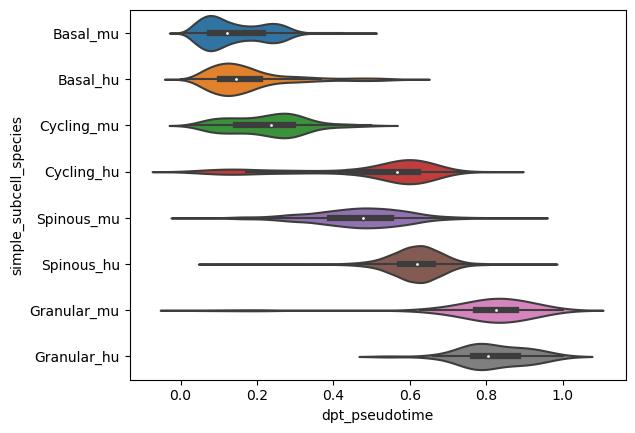

In [ ]:
#solo violin plot
sns.violinplot(data = dpt_ag_pseudo_df, x = 'dpt_pseudotime', y = "simple_subcell_species", order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"])

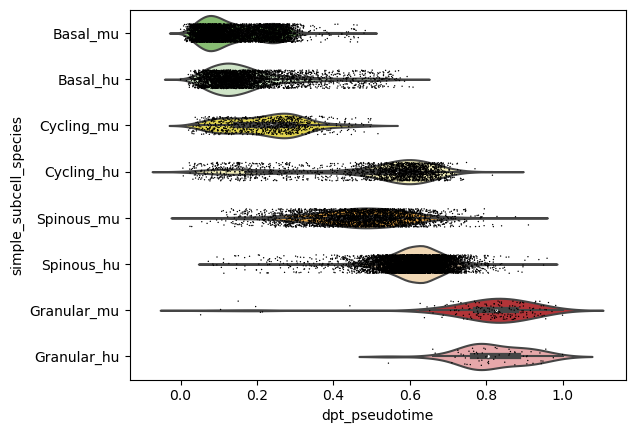

In [108]:
#violin + scatter
plot = sns.violinplot(data = dpt_ag_pseudo_df, x = 'dpt_pseudotime', y = "simple_subcell_species",palette = my_pal,
                      order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"])  
plot = sns.stripplot(x ='dpt_pseudotime', y ='simple_subcell_species', data = dpt_ag_pseudo_df, color= "black", size = 1, jitter = 0.2,
                     order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"])

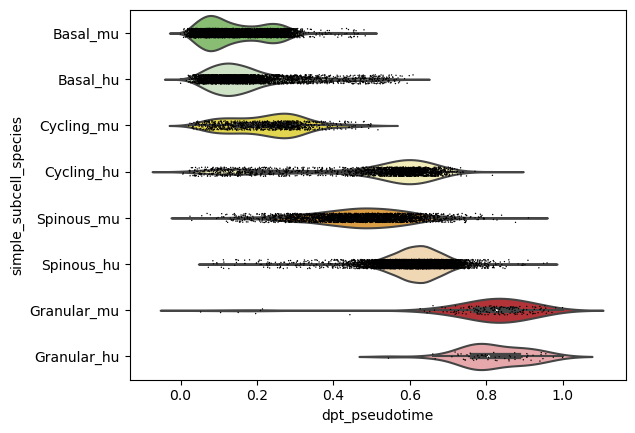

In [109]:
#violin + scatter w/ smaller jitter
plot = sns.violinplot(data = dpt_ag_pseudo_df, x = 'dpt_pseudotime', y = "simple_subcell_species", palette = my_pal,
                      order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"])  
plot = sns.stripplot(x ='dpt_pseudotime', y ='simple_subcell_species', data = dpt_ag_pseudo_df, color= "black", size = 1, jitter = 1,
                     order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"])

In [110]:
figure = plot.get_figure()
figure.savefig('C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/ag_violin_jitter_plot.pdf', dpi = 400,bbox_inches="tight")

In [112]:
#generating graphs with pvalues
#pairwise wilcoxon significance testing
basal_mwu_pval = scipy.stats.mannwhitneyu(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Basal_mu"]['dpt_pseudotime'],dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Basal_hu"]['dpt_pseudotime']).pvalue
cycling_mwu_pval = scipy.stats.mannwhitneyu(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Cycling_mu"]['dpt_pseudotime'],dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Cycling_hu"]['dpt_pseudotime']).pvalue
spinous_mwu_pval = scipy.stats.mannwhitneyu(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Spinous_mu"]['dpt_pseudotime'],dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Spinous_hu"]['dpt_pseudotime']).pvalue
granular_mwu_pval = scipy.stats.mannwhitneyu(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Granular_mu"]['dpt_pseudotime'],dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == "Granular_hu"]['dpt_pseudotime']).pvalue

In [113]:
pvalues = [basal_mwu_pval, cycling_mwu_pval, spinous_mwu_pval, granular_mwu_pval]
pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

In [114]:
plotting_parameters = {
    'data' : dpt_ag_pseudo_df,
    'x' : 'dpt_pseudotime',
    'y' : 'simple_subcell_species',
    'order' : ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"],
    "orient" : 'h',
}
pairs = [("Basal_mu", "Basal_hu"),
         ("Cycling_mu","Cycling_hu"),
         ("Spinous_mu","Spinous_hu"),
         ("Granular_mu","Granular_hu")]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Basal_mu vs. Basal_hu: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.496e-35 U_stat=8.302e+06
Cycling_mu vs. Cycling_hu: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.308e-207 U_stat=2.479e+05
Spinous_mu vs. Spinous_hu: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=3.427e+06
Granular_mu vs. Granular_hu: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.214e-01 U_stat=5.174e+03


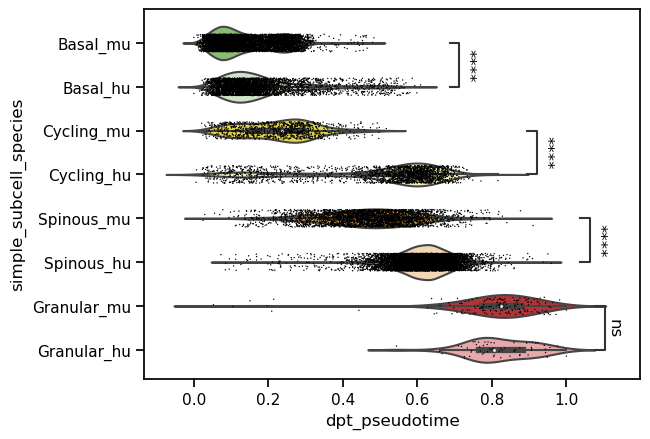

In [115]:
with sns.plotting_context('notebook', font_scale = 1):
    #create new plot
    fig = plt.figure()
    ax = sns.violinplot(**plotting_parameters, palette = my_pal)
    sns.stripplot(x ='dpt_pseudotime', y ='simple_subcell_species', data = dpt_ag_pseudo_df, color= "black", size = 1, jitter = 0.2,
                     order = ["Basal_mu", "Basal_hu", "Cycling_mu","Cycling_hu", "Spinous_mu","Spinous_hu","Granular_mu","Granular_hu"], ax = ax)
    annotator = Annotator(ax, pairs, **plotting_parameters)
    annotator.configure( test="Mann-Whitney", comparisons_correction="BH")
    _, corrected_results = annotator.apply_and_annotate()    
    plt.show
    fig.savefig('C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/ag_violin_jitter_plot_sig.pdf', dpi = 400,bbox_inches="tight")

## DIFFERENCE IN MEDIAN PLOT

In [198]:
#plotting difference in median between corresponding mice and human simple subcell types (i.e. granular_hu - granular_mu)
diff_in_median = []
for i in dpt_ag_pseudo_df['simple_subcell'].unique():
    print(i)
    diff_in_median.append(statistics.median(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == i+"_hu"]['dpt_pseudotime']) - statistics.median(dpt_ag_pseudo_df[dpt_ag_pseudo_df['simple_subcell_species'] == i+"_mu"]['dpt_pseudotime']))    

Basal
Cycling
Spinous
Granular


In [199]:
diff_in_median_df = pd.DataFrame()
diff_in_median_df['diff_median'] = diff_in_median
diff_in_median_df['group'] = ['Basal', 'Cycling', 'Spinous', 'Granular']

In [200]:
diff_in_median_df

,diff_median,group
0,0.023357,Basal
1,0.331453,Cycling
2,0.141614,Spinous
3,-0.019217,Granular


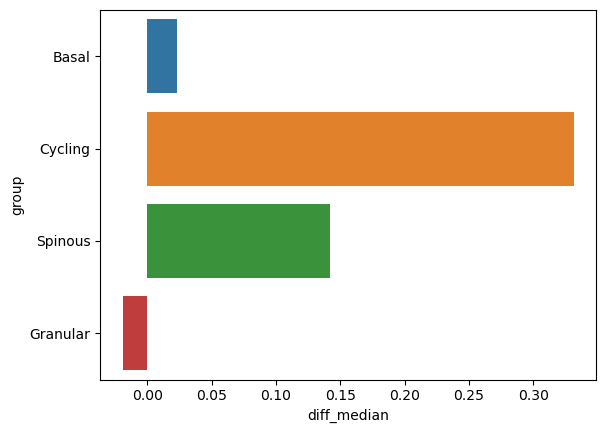

In [201]:
fig = plt.figure()
sns.barplot(data=diff_in_median_df, x="diff_median", y="group")
plt.show
fig.savefig('C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/ag_diff_in_median.pdf', dpi = 400,bbox_inches="tight")

## PLOTTING VIOLIN PLOT BY INTEGRATED_SNN_RES.0.4, MU AND HU SEPARATE

In [156]:
#subset dpt_ag_pseudo_df by species
dpt_ag_pseudo_df_mu = dpt_ag_pseudo_df[dpt_ag_pseudo_df['species'] == 'mu']
dpt_ag_pseudo_df_hu = dpt_ag_pseudo_df[dpt_ag_pseudo_df['species'] == 'hu']

In [195]:
#defining palettes
#create color palette for graph
mu_pal = {"4": "#2db77b", "0": "#f3756d", "9": "#ec69a6", "1": "#d89128", "5": "#18bdc2", "7": "#8d8cc4", "6": "#41b1e4", "2": "#a2a738", "3":"#3cb54a", "8" : "#bd77b2" }
hu_pal = {"3": "#6ca442", "4": "#11b24b", "6": "#0bb4b7", "5": "#15b578", "8": "#5c7ebf", "7": "#2fa1da", "0": "#f15f5a", "2": "#a99331", "1":"#d67f2f", "9" : "#9267ac", "11" :"#ee4b9a", "10" : "#c55d96"}

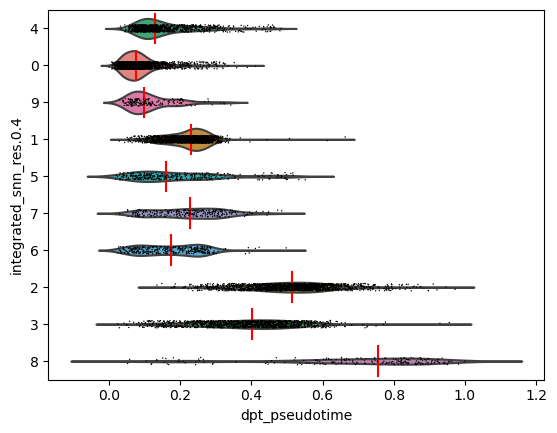

In [197]:
#MU VIOLIN PLOT
plot = sns.violinplot(data = dpt_ag_pseudo_df_mu, x = 'dpt_pseudotime', y = "integrated_snn_res.0.4", palette = mu_pal,
                      order = ["4", "0", "9" ,"1", "5","7","6","2","3","8"], inner = None)  
plot = sns.stripplot(x ='dpt_pseudotime', y ='integrated_snn_res.0.4', data = dpt_ag_pseudo_df_mu, color= "black", size = 1, jitter = 1,
                     order = ["4", "0", "9","1", "5","7","6","2","3","8"])
plot = sns.boxplot(
        medianprops={'visible': True, "color": "red"},
        whiskerprops={'visible': False},
        x="dpt_pseudotime",
        y="integrated_snn_res.0.4",
        data=dpt_ag_pseudo_df_mu,
        showfliers=False,
        showbox=False,
        showcaps=False,
    order = ["4", "0", "9","1", "5","7","6","2","3","8"])
figure = plot.get_figure()
figure.savefig('C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/mu_ag_integrated_snn_res.0.4_violin_jitter_plot.pdf', dpi = 400,bbox_inches="tight")

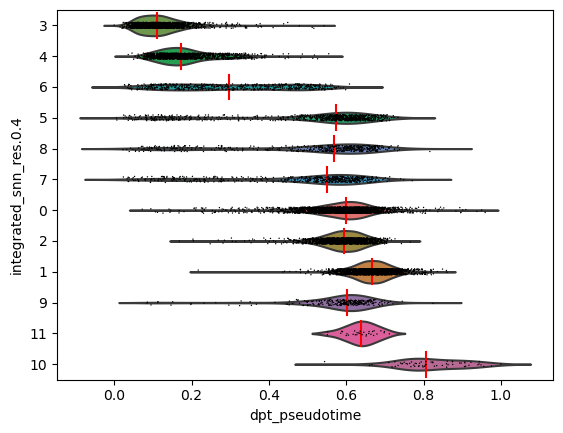

In [194]:
#HU VIOLIN PLOT
plot = sns.violinplot(data = dpt_ag_pseudo_df_hu, x = 'dpt_pseudotime', y = "integrated_snn_res.0.4", palette = hu_pal,
                      order = ["3", "4", "6" ,"5", "8","7","0","2","1","9","11", "10"], inner = None)  
plot = sns.stripplot(x ='dpt_pseudotime', y ='integrated_snn_res.0.4', data = dpt_ag_pseudo_df_hu, color= "black", size = 1, jitter = 1,
                     order = ["3", "4", "6" ,"5", "8","7","0","2","1","9","11", "10"])
plot = sns.boxplot(
        medianprops={'visible': True, "color": "red"},
        whiskerprops={'visible': False},
        x="dpt_pseudotime",
        y="integrated_snn_res.0.4",
        data=dpt_ag_pseudo_df_hu,
        showfliers=False,
        showbox=False,
        showcaps=False,
    order = ["3", "4", "6" ,"5", "8","7","0","2","1","9","11", "10"])

figure = plot.get_figure()
figure.savefig('C:/Users/Ji Lab/Documents/JID manuscript/dpt_only/hu_ag_integrated_snn_res.0.4_violin_jitter_plot.pdf', dpi = 400,bbox_inches="tight")